In [1]:
import numpy as np
import numpy.random as rnd
import scipy.stats as st
from scipy.spatial.distance import cdist
import sklearn.linear_model as lm
import sklearn.svm as sv
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

In [2]:
# Visualization parameters
%matplotlib inline
import matplotlib.pyplot as plt

fig_size = (12,10)
scatter_size = 100
axes_size = 20
plt.rc('font', size=axes_size)
plt.rc('axes', titlesize=axes_size)
plt.rc('axes', labelsize=axes_size)
plt.rc('xtick', labelsize=axes_size)
plt.rc('ytick', labelsize=axes_size)
plt.rc('legend', fontsize=axes_size)
plt.rc('figure', titlesize=axes_size)

In [3]:
# The following functions are unknown to you.

def py(y):
    """Class distribution."""
    return 1./2

def px(x1, x2):
    """Data distribution."""
    mu = np.array([0, -.5])
    Si = np.array([[.5,0],[0,2]])
    return st.multivariate_normal.pdf(np.vstack((x1,x2)).T, mean=mu, cov=Si)

def pyx(y,x1,x2):
    """Posterior function."""
    mu = np.zeros((2,))
    Si = np.array([[.1,0],[0,.1]])
    return (y<0) + y*st.multivariate_normal.cdf(-np.vstack((x1,x2)).T*2, mean=mu, cov=Si)

def pxy(y,x1,x2):
    """Class-conditional function."""
    return pyx(y, x1, x2)*px(x1, x2)/py(y)

def pxs(x1, x2):
    """Data distribution conditioned on the probability of being selected, p(x | s=1)."""
    return st.multivariate_normal.pdf(x=np.vstack((x1,x2)).T, mean=np.array([-.5, 0]), cov=np.array([[1, 0],[0, .5]]))

def pxsy(y, x1, x2):
    """Class-conditional distribution."""
    return pyx(y, x1, x2)*pxs(x1, x2) / py(y)


In [4]:
# Rejection sampling

def reject_sample2D(p, M, N, b1=(0,1), b2=(0,1)):
    """
    Perform rejection sampling on a supplied 2D distribution function.
    
    Arguments
    ---------
    p : function
        A probability distribution function, from which needs to be sampled.
    M : int
        Upper bound on pdf.
    N : int
        Number of samples to draw from
    b1 : tuple(int, int)
        Range limits for first dimension
    b2 : tuple(int, int)
        Range limits for second dimension
        
    Returns
    -------
    array
        N 2-dimensional samples drawn from pdf p.  
    """
    
    # Initialize
    n = 0;
    c = 0;

    # Preallocate
    X = np.zeros((N,2));

    while n < N:

        # Generate grid uniform random values
        x = st.uniform(loc=(b1[0], b2[0]), scale=(b1[1]-b1[0], b2[1]-b2[0])).rvs(size=(2*N, 2))

        # Generate proposal values
        uM = M*rnd.rand(2*N,)

        # Accept samples
        x = x[uM < p(x[:,0], x[:,1]), :]

        # Number of accepted samples
        nA = x.shape[0]

        # Add to existing set
        X[n:min(n + nA, N), :] = x[:min(nA, N - n), :]

        # Tick up
        n += nA;    
        c += 1;

        # Check for stalling
        if c > 1e4:
            error('too many iterations');
            
    return X

In [5]:
def plotdc(clf, ax, color='k', gridsize=(1001, 1001), linestyle='-'):
    """
    Plot the decision boundary of a classifier in a 2D scatterplot.

    Arguments
    ---------
    parameters : array(D+1,1)
        classifier parameters / weights
    ax : Axes object
        axes of a pyplot figure or subject
    colors : str
        colors of the contours in the plot (def: 'k')
    gridsize : tuple(int,int)
        number of points in the grid (def: (101, 101))
        
    Returns
    -------
    None
    """
    # Get axes limits
    xl = ax.get_xlim()
    yl = ax.get_ylim()

    # Define grid
    gx = np.linspace(xl[0], xl[1], gridsize[0])
    gy = np.linspace(yl[0], yl[1], gridsize[1])
    x, y = np.meshgrid(gx, gy)
    xy = np.vstack((x.ravel(), y.ravel())).T

    # Values of grid
    z = clf.predict(xy).reshape(gridsize)

    # Plot grid
    ax.contour(x, y, z, levels=0, colors=color, linestyles=linestyle)

In [6]:
def w_true(x):
    """True weight distribution"""
    return px(x[:,0], x[:,1]) / pxs(x[:,0], x[:,0]) 


def w_hat_lr(X, Z, l2=0.0):
    """
    Estimate importance weights based on logistic regression.

    Parameters
    ----------
    X : array
        source data (N samples by D features)
    Z : array
        target data (M samples by D features)

    Returns
    -------
    array
        importance weights (N samples by 1)

    """
    # Data shapes
    N, DX = X.shape
    M, DZ = Z.shape

    # Assert equivalent dimensionalities
    if not DX == DZ:
        raise ValueError('Dimensionalities of X and Z should be equal.')

    # Make domain-label variable
    y = np.concatenate((np.zeros((N, 1)),
                        np.ones((M, 1))), axis=0)

    # Concatenate data
    XZ = np.concatenate((X, Z), axis=0)

    # Call a logistic regressor
    lr = lm.LogisticRegression(C=l2)

    # Predict probability of belonging to target using cross-validation
    preds = cross_val_predict(lr, XZ, y[:, 0])
    
    # Weight clipping
    preds = np.minimum(clip, np.maximum(0, preds))

    # Return predictions for source samples
    return preds[:N]

def w_hat_kde(X, Z, clip=1000):
        """
        Estimate importance weights based on kernel density estimation.

        Parameters
        ----------
        X : array
            source data (N samples by D features)
        Z : array
            target data (M samples by D features)

        Returns
        -------
        array
            importance weights (N samples by 1)

        """
        # Data shapes
        N, DX = X.shape
        M, DZ = Z.shape

        # Assert equivalent dimensionalities
        if not DX == DZ:
            raise ValueError('Dimensionalities of X and Z should be equal.')

        # Compute probabilities based on source kernel densities
        pT = st.gaussian_kde(Z.T).pdf(X.T)
        pS = st.gaussian_kde(X.T).pdf(X.T)

        # Check for numerical problems
        if np.any(np.isnan(pT)) or np.any(pT == 0):
            raise ValueError('Source probabilities are NaN or 0.')
        if np.any(np.isnan(pS)) or np.any(pS == 0):
            raise ValueError('Target probabilities are NaN or 0.')
            
        # Take ratio
        iw = pT / pS
            
        # Weight clipping
        iw = np.minimum(clip, np.maximum(0, iw))

        # Return the ratio of probabilities
        return iw
    
def w_hat_nn(X, Z, clip=1000):
        """
        Estimate importance weights based on nearest-neighbours.

        Parameters
        ----------
        X : array
            source data (N samples by D features)
        Z : array
            target data (M samples by D features)

        Returns
        -------
        iw : array
            importance weights (N samples by 1)

        """
        # Data shapes
        N, DX = X.shape
        M, DZ = Z.shape

        # Assert equivalent dimensionalities
        if not DX == DZ:
            raise ValueError('Dimensionalities of X and Z should be equal.')

        # Compute Euclidean distance between samples
        d = cdist(X, Z, metric='euclidean')

        # Count target samples within each source Voronoi cell
        ix = np.argmin(d, axis=1)
        iw, _ = np.array(np.histogram(ix, np.arange(N+1)))

        # Laplace smoothing
        iw = (iw + 1.) / (N + 1)

        # Weight clipping
        iw = np.minimum(clip, np.maximum(0, iw))

        # Return weights
        return iw

In [7]:
# Rejection sampling intervals
b1 = [-5, 5]
b2 = [-5, 5]

In [8]:
# Construct our unbiased unlabeled test data

# Sample sizes (M for testing)
M = 100

# Perform rejection sampling to obtain data from data distribution p(x)
Z = reject_sample2D(lambda x1,x2: px(x1,x2), 1, M, b1=b2, b2=b2)

In [9]:
# Sample size
N = 50

# Sample from positive class (i.e. y=+1)
Xp = reject_sample2D(lambda x1,x2: pxsy(+1, x1, x2), 1, int(N*py(+1)), b1=b1, b2=b2)

# Sample from negative class (i.e. y=-1)
Xn = reject_sample2D(lambda x1,x2: pxsy(-1, x1, x2), 1, int(N*py(-1)), b1=b1, b2=b2)

# Concatenate both sets
X = np.vstack((Xp, Xn))

# Make label vector
y = np.hstack((-np.ones(Xp.shape[0],), np.ones(Xn.shape[0],))).T

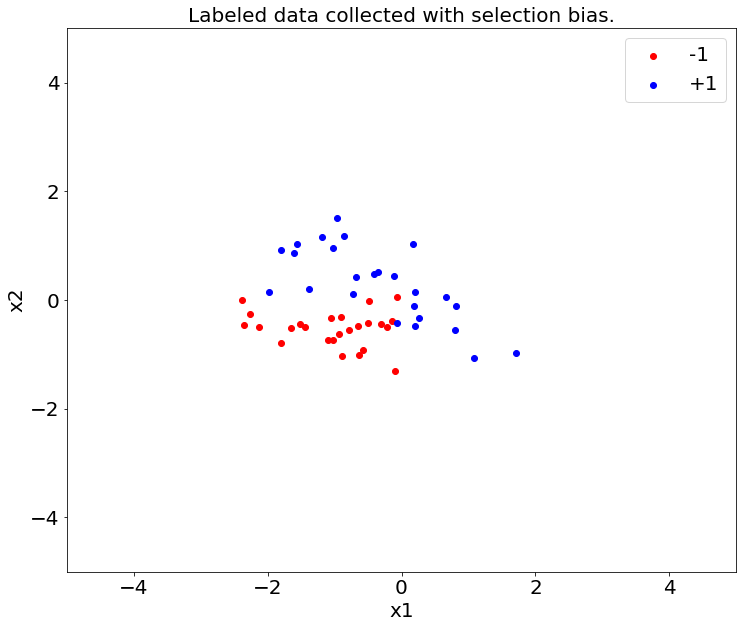

In [10]:
# Scatterplot the data

fig, ax = plt.subplots(figsize=fig_size)

ax.scatter(X[y==-1, 0], X[y==-1, 1], c='r', label='-1')
ax.scatter(X[y==+1, 0], X[y==+1, 1], c='b', label='+1')

ax.legend()
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(b1[0], b1[1])
ax.set_ylim(b2[0], b2[1])
ax.set_title('Labeled data collected with selection bias.');

In [11]:
# Fit a linear model and make predictions

# Initialize polynomial SVM of degree 1
model1 = sv.SVC(kernel='poly', degree=1, gamma='auto')

# Perform grid search cross-validation to find optimal C
grid_searcher = GridSearchCV(model1, param_grid=dict(C=np.logspace(-4,3,8)), cv=5).fit(X,y)
model1 = sv.SVC(kernel='poly', degree=1, C=grid_searcher.best_estimator_.C, gamma='auto')

# Fit on training data
model1.fit(X,y);

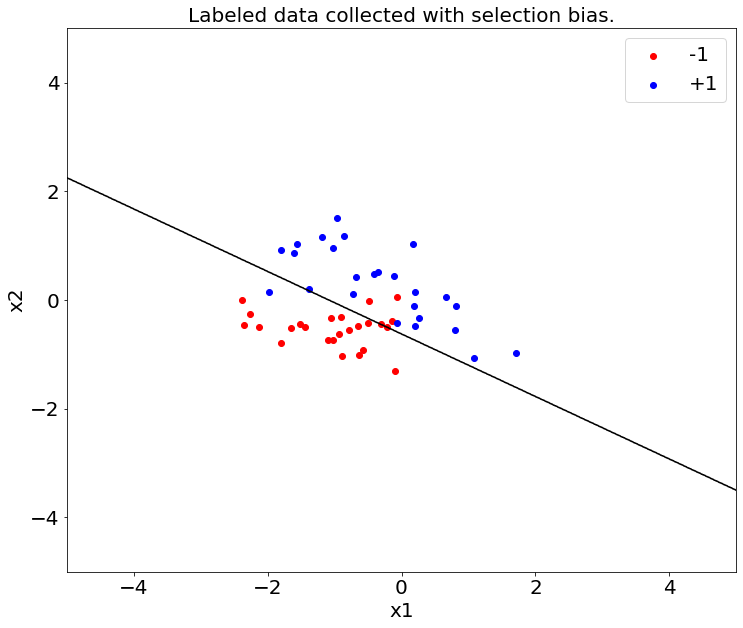

In [12]:
# Scatterplot the data

fig, ax = plt.subplots(figsize=fig_size)

ax.scatter(X[y==-1, 0], X[y==-1, 1], c='r', label='-1')
ax.scatter(X[y==+1, 0], X[y==+1, 1], c='b', label='+1')

ax.legend()
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(b1[0], b1[1])
ax.set_ylim(b2[0], b2[1])
ax.set_title('Labeled data collected with selection bias.');

# Plot classifier
plotdc(model1, ax, color='k')

In [13]:
# Draw a test set from the whole population

# Sample from positive class (i.e. y=+1)
Zp = reject_sample2D(lambda x1,x2: pxy(+1, x1, x2), 1, int(M*py(+1)), b1=b1, b2=b2)

# Sample from negative class (i.e. y=-1)
Zn = reject_sample2D(lambda x1,x2: pxy(-1, x1, x2), 1, int(M*py(-1)), b1=b1, b2=b2)

# Concatenate both sets
Z = np.vstack((Zp, Zn))

# Make label vector
u = np.hstack((-np.ones(Zp.shape[0],), np.ones(Zn.shape[0],))).T

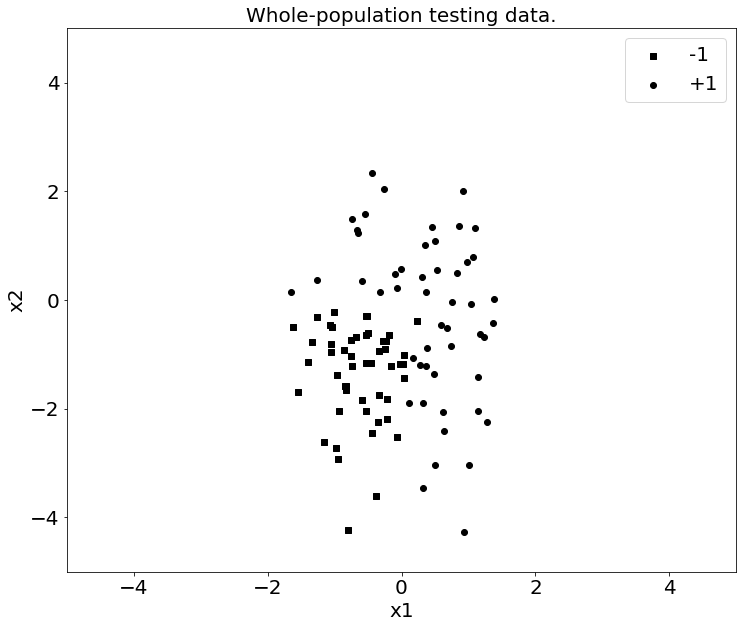

In [14]:
# Scatterplot the data

fig, ax = plt.subplots(figsize=fig_size)

ax.scatter(Z[u==-1, 0], Z[u==-1, 1], c='k', marker='s', label='-1')
ax.scatter(Z[u==+1, 0], Z[u==+1, 1], c='k', marker='o', label='+1')

ax.legend()
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(b1[0], b1[1])
ax.set_ylim(b2[0], b2[1])
ax.set_title('Whole-population testing data.');

In [15]:
# Model accuracy on whole population
print('Accuracy on testing set: ' + str(model1.score(Z, u)))

Accuracy on testing set: 0.8


In [16]:
# Increase degree of polynomial to 2 (quadratic)

# Perform grid search cross-validation to get optimal C
model2 = sv.SVC(kernel='poly', degree=2, gamma='auto')
grid_searcher = GridSearchCV(model2, param_grid=dict(C=np.logspace(-4,3,8)), cv=5).fit(X,y)

model2 = sv.SVC(kernel='sigmoid', degree=24, C=.001, gamma='auto')#grid_searcher.best_estimator_.C)

# Fit on training data
model2.fit(X,y);

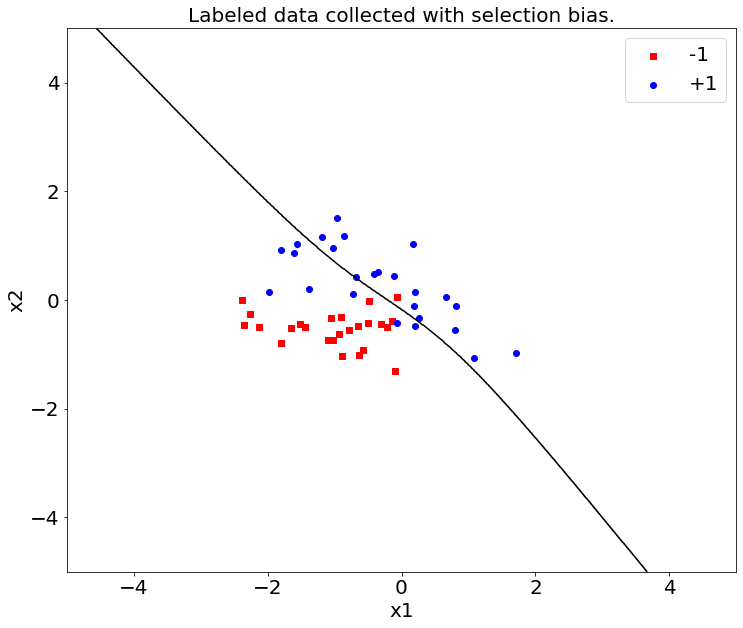

In [17]:
# Scatterplot the data

fig, ax = plt.subplots(figsize=fig_size)
ax.scatter(X[y==-1, 0], X[y==-1, 1], c='r', marker='s', label='-1')
ax.scatter(X[y==+1, 0], X[y==+1, 1], c='b', marker='o', label='+1')

ax.legend()
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(b1[0], b1[1])
ax.set_ylim(b2[0], b2[1])
ax.set_title('Labeled data collected with selection bias.');

# Plot classifier
plotdc(model2, ax, color='k')

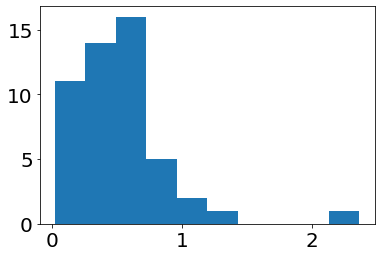

In [18]:
# Estimate weights
    
W = w_hat_kde(X, Z)

plt.hist(W);

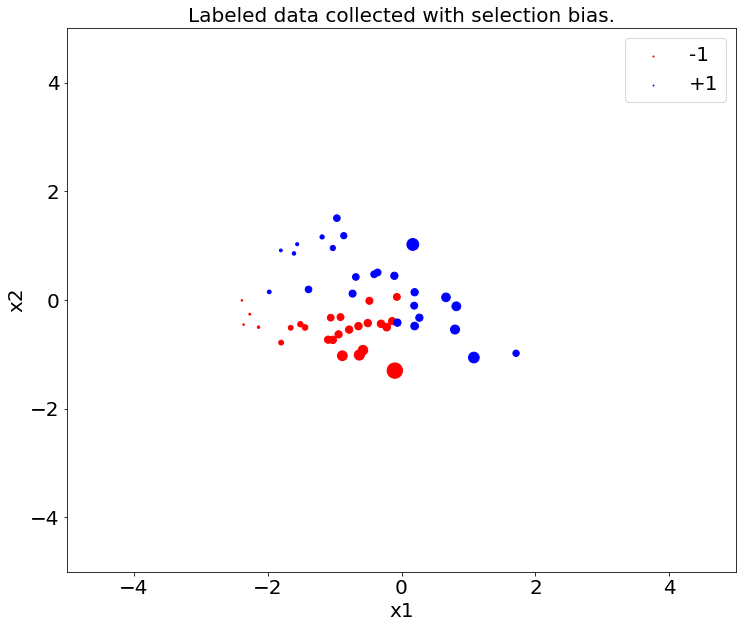

In [19]:
# Scatterplot the data

fig, ax = plt.subplots(figsize=fig_size)
ax.scatter(X[y==-1, 0], X[y==-1, 1], c='r', s=W[y==-1]*scatter_size, label='-1')
ax.scatter(X[y==+1, 0], X[y==+1, 1], c='b', s=W[y==+1]*scatter_size, label='+1')

ax.legend(markerscale=0.1)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(b1[0], b1[1])
ax.set_ylim(b2[0], b2[1])
ax.set_title('Labeled data collected with selection bias.');

In [20]:
# Fit a weighted model and make predictions

# Cross-validate SVM for optimal C
model3 = sv.SVC(kernel='poly', degree=1, gamma='auto')
grid_searcher = GridSearchCV(model3, param_grid=dict(C=np.logspace(-4,3,8)), cv=5).fit(X,y, sample_weight=w_true(X))

model3 = sv.SVC(kernel='sigmoid', degree=1, C=1., gamma='auto')#grid_searcher.best_estimator_.C)

# Fit on given data
model3.fit(X,y, sample_weight=W);

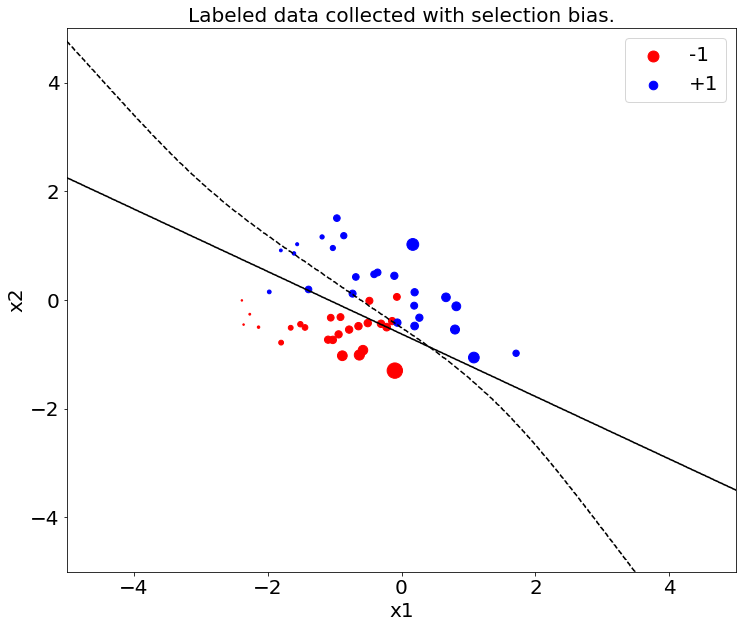

In [21]:
# Scatterplot the data

fig, ax = plt.subplots(figsize=fig_size)
ax.scatter(X[y==-1, 0], X[y==-1, 1], c='r', s=W[y==-1]*scatter_size, label='-1')
ax.scatter(X[y==+1, 0], X[y==+1, 1], c='b', s=W[y==+1]*scatter_size, label='+1')

ax.legend(markerscale=1.)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(b1[0], b1[1])
ax.set_ylim(b2[0], b2[1])
ax.set_title('Labeled data collected with selection bias.');

# Plot classifier
plotdc(model1, ax, linestyle='-')
plotdc(model3, ax, linestyle='--')

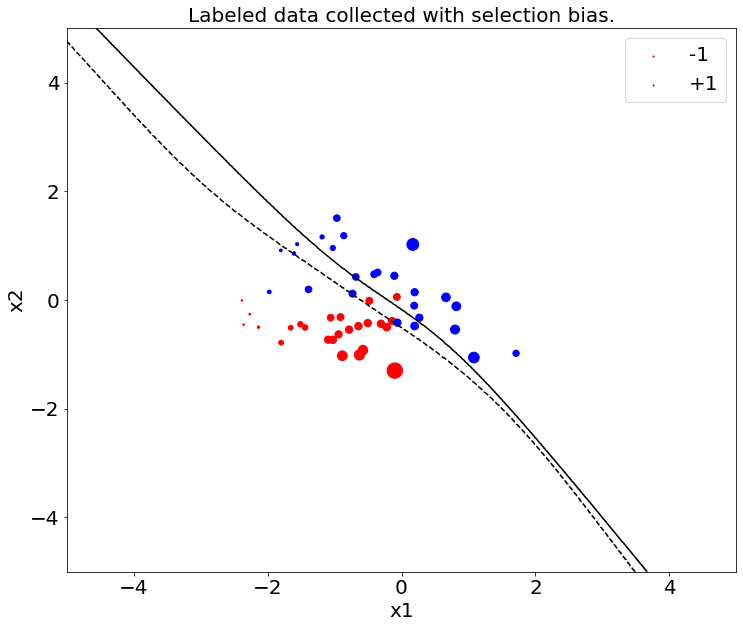

In [22]:
# Scatterplot the data

fig, ax = plt.subplots(figsize=fig_size)
ax.scatter(X[y==-1, 0], X[y==-1, 1], c='r', s=W[y==-1]*scatter_size, label='-1')
ax.scatter(X[y==+1, 0], X[y==+1, 1], c='b', s=W[y==+1]*scatter_size, label='+1')

ax.legend(markerscale=0.1)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(b1[0], b1[1])
ax.set_ylim(b2[0], b2[1])
ax.set_title('Labeled data collected with selection bias.');

# Plot classifier
plotdc(model2, ax, linestyle='-')
plotdc(model3, ax, linestyle='--')

In [23]:
# Model accuracy

print('Accuracy of degree-2 polynomial SVM on test set: ' + str(model2.score(Z, u)))
print('Accuracy of weighted degree-2 polynomial SVM on test set: ' + str(model3.score(Z, u)))

Accuracy of degree-2 polynomial SVM on test set: 0.82
Accuracy of weighted degree-2 polynomial SVM on test set: 0.82
